# Effect of underresolved meshes on species boundary layers

This notebook highlights the effect of low mesh resolution on diffusive fluxes, convective fluxes, and source terms due to reactions in a standard finite volume discretization of reactive species boundary layers. To obtain realistic profiles, a coupled system of 1D reaction-diffusion equations is solved.

## Mathematical problem

We are looking at a single reaction of type $2A+B\rightarrow P$, where the transfer species $A$ reacts with some bulk component $B$ to the desired product $P$. The reaction-diffusion equations for such a system read
$$
\frac{\mathrm{d}^2 c_A}{\mathrm{d}x^2} = 2k c_A^2 c_B\\
\frac{\mathrm{d}^2 c_B}{\mathrm{d}x^2} = k c_A^2 c_B\\
\frac{\mathrm{d}^2 c_P}{\mathrm{d}x^2} = -k c_A^2 c_B
$$

where $k$ denotes the reaction rate constant. The boundary conditions for $A$ for a domain of length $L$ are $c_A|_{x=0} = 1$ and $c_A|_{x=L} = 0$. The boundary at $x=0$ may be considered as the gas-liquid interface. For species $B$, the gradient at $x=0$ is set to zero, e.g. no flux of $B$ passes the interface, and at $x=L$ a fixed value is applied, e.g. the bulk is always saturated with $B$. Expressed in mathematical terms the same condtions read
$$
\left.\frac{\mathrm{d} c_B}{\mathrm{d}x}\right\vert_{x=0} = 0\quad \text{and} \quad c_B|_{x=L} = 1.
$$

For the product species, at both boundaries the concentration value is set to zero. For $P$ there are several sensible boundary conditions, but the chosen ones are sufficient to create a realistic profile.

## Solving a single boundary value problem using SciPy

In [47]:
import helper_module as hm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.integrate import solve_bvp, trapz

%matplotlib inline
rc('text', usetex=True)
alpha = 0.3
lw = hm.line_width

def func(x, c):
    source = 1000*np.power(c[0], 2)*c[2]
    return np.vstack((c[1], 2*source, c[3], source, c[5], -source))

def bc(c_a, c_b):
    return np.array([c_a[0] - 1.0, c_a[3], c_a[4], c_b[0], c_b[2] - 1.0, c_b[4]])

x = np.linspace(0, 1.0, 100)
c_init = np.zeros((6, x.size))
res = solve_bvp(func, bc, x, c_init)

x_plot = np.linspace(0, 1, 100)
y_plot_a = res.sol(x_plot)[0] # species A
y_plot_b = res.sol(x_plot)[2] # species B
y_plot_p = res.sol(x_plot)[4] # species P

## Helper functions

In [48]:
def compute_derivative(x, y):
    dev_inner = [ (y[i-1] - y[i+1]) / (x[i-1] - x[i+1]) for i in range(1, x.shape[0]-1) ]
    dev_0 = [(y[0] - y[1]) / (x[0] - x[1])]
    dev_1 = [(y[-2] - y[-1]) / (x[-2] - x[-1])]
    return np.asarray(dev_0 + dev_inner + dev_1)


def compute_cell_average(n_cells, n_p, ind):
    cell_width = 1.0/n_cells
    fi = [0]
    while fi[-1] + cell_width < 1.0:
        fi.append(fi[-1] + cell_width)
    fi.append(1.0)
    y_av = []
    for cell in range(0, len(fi)-1):
        x_cell = np.linspace(fi[cell], fi[cell+1], n_p)
        y_cell = res.sol(x_cell)[ind]
        y_av.append(trapz(y_cell, x_cell) / (fi[cell+1] - fi[cell]))
    return np.asarray(y_av)
    

def compute_cell_average_simple(profile, n_cells):
    n_points = profile.shape[0]
    points_per_cell = int(n_points / n_cells)
    left_over_points = n_points % points_per_cell
    l_bounds = range(0, n_points - points_per_cell - left_over_points + 1, points_per_cell)
    u_bounds = range(points_per_cell, n_points - left_over_points + 1, points_per_cell)
    profile_av = []
    for lb, ub in zip(l_bounds, u_bounds):
        profile_av.append(np.sum(profile[lb:ub]) / points_per_cell)
    if left_over_points > 0:
        profile_av.append(np.sum(profile[-left_over_points:]) / left_over_points)
    return np.asarray(profile_av)


def interpolate_2nn(x, y, x_p):
    diff = np.absolute(x - x_p)
    ind_sort = np.argsort(diff)
    w_1 = 1.0 / (diff[ind_sort[0]] + 1.0E-15)
    w_2 = 1.0 / (diff[ind_sort[1]] + 1.0E-15)
    val = (y[ind_sort[0]] * w_1 + y[ind_sort[1]] * w_2) / (w_1 + w_2)
    return val


def compute_discretization_error(x, y, n_cells):
    y_av = compute_cell_average(n_cells, 100, 0)
    y_dev = compute_derivative(x, y)
    cell_width = 1.0 / n_cells
    m_0_lin = (y_av[0] - 1.0) / cell_width * 2
    m_1_lin = ( y_av[1] - y_av[0]) / cell_width
    val_1_lin = 0.5 * (y_av[0] + y_av[1])
    m_1_ref =  interpolate_2nn(x, y_dev, cell_width)
    val_1_ref = interpolate_2nn(x, y, cell_width)
    return y_dev[0] - m_0_lin, m_1_ref - m_1_lin, val_1_ref - val_1_lin


def create_base_plot():
    fig = plt.figure(figsize=(hm.figure_width, 14))
    grid = plt.GridSpec(3, 3, wspace=0.1, hspace=0.3)
    ax1 = plt.subplot(grid[0, :])
    ax2 = plt.subplot(grid[1, 0])
    ax3 = plt.subplot(grid[1, 1])
    ax4 = plt.subplot(grid[1, 2])
    # upper plot
    ax1.plot([], [], ls='-', c='C0', linewidth=lw, label=r"$\tilde{c}_A$")
    ax1.set_xlabel(r"$x/\delta_c$", fontsize=hm.fontsize_label)
    ax1.tick_params(labelsize=hm.fontsize_tick)
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.0])
    ax1.legend(fontsize=hm.fontsize_legend)
    # lower plots
    labels = [r"$(\mathrm{d}_x \tilde{c}_{ref} -\mathrm{d}_x \tilde{c}_{num})_{f_0}$",
          r"$(\mathrm{d}_x \tilde{c}_{ref} -\mathrm{d}_x \tilde{c}_{num})_{f_1}$",
          r"$(\tilde{c}_{ref} - \tilde{c}_{num})_{f_1}$"]
    for ax, label in zip([ax2, ax3, ax4], labels):
        ax.set_yticks([0.0])
        ax.axhline(0.0, lw=2, color="k", ls=":")
        ax.set_xlabel(r"$\delta_c / \Delta x$", fontsize=hm.fontsize_label)
        ax.tick_params(labelsize=hm.fontsize_tick)
        ax.plot([], [], lw=lw, color="C3", ls=":", label=label)
        ax.legend(fontsize=hm.fontsize_legend)
    return fig, ax1, ax2, ax3, ax4

## Transfer species

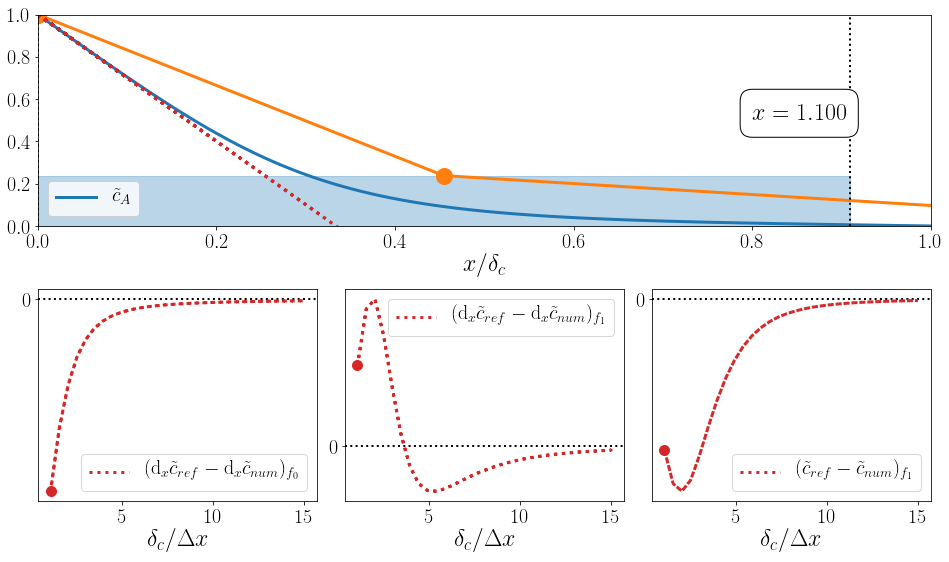

In [84]:
fig, ax1, ax2, ax3, ax4 = create_base_plot()

dev_a = compute_derivative(x_plot, y_plot_a)
frames = 30
n_cells_array = np.linspace(1.1, 15.0, frames)
n_cells_array = np.append(n_cells_array, n_cells_array[-2::-1])
bbox = dict(facecolor='white', alpha=1.0, boxstyle='round,pad=0.5')

diff_m_0 = []
diff_m_1 = []
diff_v_1 = []
for nc in n_cells_array:
    m_0, m_1, v_1 = compute_discretization_error(x_plot, y_plot_a, nc)
    diff_m_0.append(m_0)
    diff_m_1.append(m_1)
    diff_v_1.append(v_1)
    
dot_plot = [
    ax2.scatter([], [], marker="o", color="C3", s=100),
    ax3.scatter([], [], marker="o", color="C3", s=100),
    ax4.scatter([], [], marker="o", color="C3", s=100)
]

faces_ind = []
fills = []

def init_a():
    n_init = 1.1
    cell_width = 1.0 / n_init
    cell_av = compute_cell_average(n_init, 10, 0)
    start = len(ax1.lines)
    for fi, av_i in enumerate(cell_av):
        faces_ind.append(start)
        start += 1
        ax1.axvline(1.0/n_init*fi, 0, 1, linestyle=':', color='k', lw=2)
        fills.append(ax1.fill_between([1.0/n_init*fi, 1.0/n_init*(fi+1)], [0.0, 0.0], [av_i, av_i],
                                      color="C0", alpha=alpha))
    # reference solution
    ax1.plot(x_plot, y_plot_a, ls='-', c='C0', linewidth=lw)
    # linear approximation
    cell_width = 1.0/1.1
    ax1.plot([0.0, 0.5*cell_width, 1.5*cell_width], [1.0, cell_av[0], cell_av[1]], c='C1', linewidth=lw, marker="o", ms=16)
    ax2.plot(n_cells_array, diff_m_0, lw=lw, color="C3", ls=":")
    dot_plot[0]._offsets = np.c_[[n_init], [interpolate_2nn(n_cells_array, diff_m_0, n_init)]]
    ax3.plot(n_cells_array, diff_m_1, lw=lw, color="C3", ls=":")
    #dot_plot[1].set_data([n_init], [interpolate_2nn(n_cells_array, diff_m_1, n_init)])
    ax4.plot(n_cells_array, diff_v_1, lw=lw, color="C3", ls=":")
    #dot_plot[2].set_data([n_init], [interpolate_2nn(n_cells_array, diff_v_1, n_init)])
        
n_cells_text = ax1.text(0.8, 0.5, r"x = 00.00", fontsize=hm.fontsize_label, bbox=bbox)
def text_formatter(number):
    if number < 10:
        return "{:2.3f}".format(number)
    else:
        return "{:2.2f}".format(number)
def update_a(frame):
    n_cells = n_cells_array[frame]
    cell_width = 1.0 / n_cells
    cell_av = compute_cell_average(n_cells, 10, 0)
    for ind in faces_ind[::-1]:
        del ax1.lines[ind]
    del faces_ind[:]
    for area in fills:
        #ax1.collections.remove(area)
        area.remove()
    del fills[:]
    start = len(ax1.lines)
    for fi, av_i in enumerate(cell_av):
        faces_ind.append(start)
        start += 1
        ax1.axvline(1.0/n_cells*fi, 0, 1, linestyle=':', color='k', lw=2)
        fills.append(ax1.fill_between([1.0/n_cells*fi, 1.0/n_cells*(fi+1)], [0.0, 0.0], [av_i, av_i],
                                      color="C0", alpha=alpha))
    # linear approximation
    #ax1.plot([0.0, 0.5*cell_width, 1.5*cell_width], [1.0, cell_av[0], cell_av[1]], c='C1', linewidth=lw, marker="o", ms=16)
    ax1.plot([0.0, 0.5 * cell_width], [1.0, 1.0 + 0.5 * cell_width * dev_a[0]], ls=":", c="C3", linewidth=lw)
    #m_1 = interpolate_2nn(x_plot, dev_a, cell_width)
    #val_1 = interpolate_2nn(x_plot, y_plot_a, cell_width)
    #ax1.plot([0.5*cell_width, 1.5*cell_width], [val_1 - 0.5 * cell_width * m_1, val_1 + 0.5 * cell_width * m_1],
    #         ls=":", c="C3", linewidth=lw)
    #ax1.text(0.8, 0.5, r"$\delta_c/\Delta_x = {:4.2f}$".format(n_cells), fontsize=hm.fontsize_label, bbox=bbox)
    number = r"$ x = " + text_formatter(n_cells) + r"$"
    #ax1.text(0.8, 0.5, r"x = " + number, fontsize=hm.fontsize_label, bbox=bbox)
    n_cells_text.set_text(number)
    dot_plot[0]._offsets = np.c_[[n_cells], [interpolate_2nn(n_cells_array, diff_m_0, n_cells)]]
    dot_plot[1]._offsets = np.c_[[n_cells], [interpolate_2nn(n_cells_array, diff_m_1, n_cells)]]
    dot_plot[2]._offsets = np.c_[[n_cells], [interpolate_2nn(n_cells_array, diff_v_1, n_cells)]]
    
init_a()
for frame in range(2*frames-1):
    update_a(frame)
    plt.savefig("test/flux_a_{:03d}.png".format(frame),bbox_inches="tight")

<Figure size 432x288 with 0 Axes>